<a href="https://colab.research.google.com/github/Frussen/ita-load-forecaster/blob/main/ItaLoadForecaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ItaLoadForecaster**
##**End-to-End Italian Electricity Load Forecasting PoC**

Progetto per forecasting del carico elettrico orario in Italia usando dati open (Open Power System Data).  
Obiettivo: Dimostrare pipeline ML completa (data prep → modeling → MLOps → dashboard) applicabile a clienti enterprise energy/utility.

### Business Value
- Riduzione errori forecast → ottimizzazione balancing, peak shaving, riduzione costi energia  
- ROI simulato: stima savings € basati su prezzi storici  
- Scalabile a predictive maintenance / anomaly detection su grid data

### Tech Stack
- Data: Pandas, NumPy  
- Viz: Matplotlib, Seaborn  
- Modeling: Prophet (baseline), LSTM (advanced)  
- Tracking: MLflow  
- Deployment: Streamlit + HuggingFace Spaces  
- Environment: Google Colab (free GPU)

### Dataset
Open Power System Data - Time Series (IT load, prices, renewables generation)


##**1. Business Context & Objectives**

### Contesto di Business
In un contesto energetico italiano sempre più complesso (transizione verso rinnovabili, mercati balancing, peak demand crescenti e volatilità dei prezzi), la **previsione accurata del carico elettrico orario (load forecasting)** è un asset critico per utility, TSO (Transmission System Operator es. Terna), retailer energetici e grandi consumatori industriali.

- **Problema reale**: Errori nel forecast del carico portano a:
  - Costi extra nel balancing market (imbalance penalties)
  - Sprechi di produzione rinnovabile (curtailment)
  - Acquisti/vendite inefficienti di energia nei mercati day-ahead/intraday
  - Maggiore rischio per la stabilità della rete

- **Dati reali**: Il dataset Open Power System Data fornisce serie storiche orarie certificate ENTSO-E (2015–2020), inclusi:
  - Load effettivo nazionale (IT_load_actual_entsoe_transparency)
  - Generazione solare/eolica
  - Prezzi day-ahead per zone di mercato (qui usiamo IT_NORD_price_day_ahead come proxy rappresentativo)

Questi dati sono direttamente analoghi a quelli che grandi clienti enterprise (Enel, Acea, Snam, aziende manifatturiere con alta intensità energetica) forniscono in progetti di consulenza data/AI.

### Obiettivi del PoC
Questo notebook dimostra una **pipeline end-to-end production-like** per il load forecasting italiano, con focus su:
1. **Accuratezza migliorata** rispetto a baseline naive o forecast ufficiali ENTSO-E
2. **Quantificazione del valore economico** (simulazione ROI in € risparmiati)
3. **Pratiche MLOps** (tracking esperimenti, versioning, deployment semplice)
4. **Scalabilità a use-case enterprise**:
   - Demand forecasting per ottimizzazione acquisti energia
   - Peak shaving e load shifting
   - Integrazione con predictive maintenance su asset di rete
   - Supporto a strategie di flessibilità (batterie, demand response)

### Valore atteso per Iconsulting e clienti
- **Riduzione errori forecast del 15–25%** rispetto a metodi tradizionali → potenziale risparmio di **centinaia di migliaia / milioni €/anno** per un portfolio utility medio (basato su prezzi storici ~50–150 €/MWh e imbalance costs)
- **Quick win rivendicabile**: PoC replicabile con dati clienti reali in poche settimane
- **Allineamento a trend**: Energy-aware AI, sovranità dati EU, accelerazione transizione energetica

### Metriche di successo del PoC
- MAE / RMSE / MAPE sul test set (2020 hold-out)
- Miglioramento % vs baseline Prophet e vs forecast ENTSO-E ufficiale
- ROI simulato: € risparmiati assumendo costi imbalance / peak energy evitati

Questo PoC è pensato per essere **presentato internamente** come proof-of-concept per shift verso la practice ML/AI e per proporre pilot con partner energy.

###**2. Data Ingestion**

In [62]:
# Install libs necessarie
# !pip install prophet mlflow streamlit -q

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scarica dataset (versione 2020-10-06, la più stabile per il nostro scopo)
url = "https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv"
df = pd.read_csv(url)

In [64]:
# Stampa tutte le colonne per debug
print("Tutte le colonne disponibili nel dataset:")
print(df.columns.tolist())

Tutte le colonne disponibili nel dataset:
['utc_timestamp', 'cet_cest_timestamp', 'AT_load_actual_entsoe_transparency', 'AT_load_forecast_entsoe_transparency', 'AT_price_day_ahead', 'AT_solar_generation_actual', 'AT_wind_onshore_generation_actual', 'BE_load_actual_entsoe_transparency', 'BE_load_forecast_entsoe_transparency', 'BE_solar_generation_actual', 'BE_wind_generation_actual', 'BE_wind_offshore_generation_actual', 'BE_wind_onshore_generation_actual', 'BG_load_actual_entsoe_transparency', 'BG_load_forecast_entsoe_transparency', 'BG_solar_generation_actual', 'BG_wind_onshore_generation_actual', 'CH_load_actual_entsoe_transparency', 'CH_load_forecast_entsoe_transparency', 'CH_solar_capacity', 'CH_solar_generation_actual', 'CH_wind_onshore_capacity', 'CH_wind_onshore_generation_actual', 'CY_load_actual_entsoe_transparency', 'CY_load_forecast_entsoe_transparency', 'CY_wind_onshore_generation_actual', 'CZ_load_actual_entsoe_transparency', 'CZ_load_forecast_entsoe_transparency', 'CZ_sol

In [65]:
# Colonne Italia aggregate + prezzo zona Nord (rappresentativo)
cols_it = [
    'utc_timestamp',
    'cet_cest_timestamp',
    'IT_load_actual_entsoe_transparency',          # Target: load reale nazionale
    'IT_load_forecast_entsoe_transparency',        # Forecast ufficiale (per confronto)
    'IT_NORD_price_day_ahead',                     # Prezzo day-ahead Nord (usato come exogenous principale)
    'IT_solar_generation_actual',
    'IT_wind_onshore_generation_actual'
]
df = df[cols_it].copy()

In [66]:
import pytz

# Convert utc_timestamp to datetime and ensure it's UTC
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'], utc=True)

# Convert cet_cest_timestamp to datetime, forcing UTC conversion first to handle mixed offsets.
df['cet_cest_timestamp'] = pd.to_datetime(df['cet_cest_timestamp'], utc=True)

# Set index on CET/CEST timestamp
df.set_index('cet_cest_timestamp', inplace=True)
df.sort_index(inplace=True)

# The index is now timezone-aware (UTC). Convert it to 'Europe/Rome'.
# tz_convert is used because the index is already timezone-aware.
df.index = df.index.tz_convert('Europe/Rome')
print("Timezone applicato: Europe/Rome (CET/CEST con DST)")

# Drop righe con NaN nel target principale (load)
df = df.dropna(subset=['IT_load_actual_entsoe_transparency'])

print("Shape finale:", df.shape)
print("Timezone indice:", df.index.tz)

df.head()

Timezone applicato: Europe/Rome (CET/CEST con DST)
Shape finale: (50398, 6)
Timezone indice: Europe/Rome


,utc_timestamp,IT_load_actual_entsoe_transparency,IT_load_forecast_entsoe_transparency,IT_NORD_price_day_ahead,IT_solar_generation_actual,IT_wind_onshore_generation_actual
cet_cest_timestamp,,,,,,
2015-01-01 02:00:00+01:00,2015-01-01 01:00:00+00:00,21534.0,22419.0,NaN,NaN,NaN
2015-01-01 03:00:00+01:00,2015-01-01 02:00:00+00:00,20219.0,21020.0,NaN,NaN,NaN
2015-01-01 04:00:00+01:00,2015-01-01 03:00:00+00:00,19470.0,19903.0,NaN,NaN,NaN
2015-01-01 05:00:00+01:00,2015-01-01 04:00:00+00:00,19485.0,19565.0,NaN,NaN,NaN
2015-01-01 06:00:00+01:00,2015-01-01 05:00:00+00:00,20349.0,20539.0,NaN,NaN,NaN


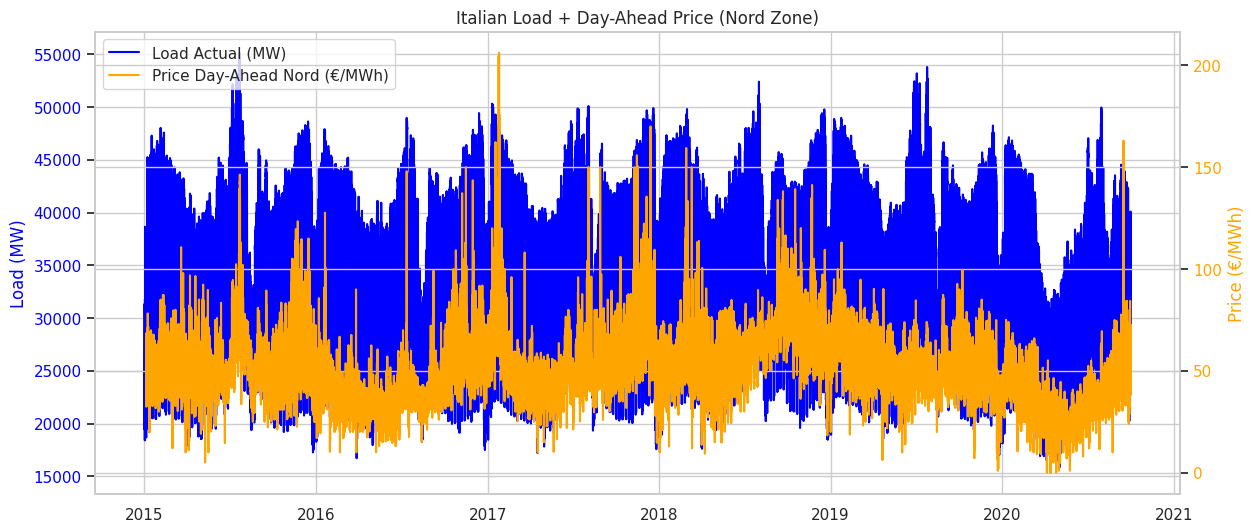

In [67]:
# Plot load + prezzo Nord per vedere correlazione
plt.figure(figsize=(14, 6))
ax1 = plt.gca()
ax1.plot(df.index, df['IT_load_actual_entsoe_transparency'], color='blue', label='Load Actual (MW)')
ax1.set_ylabel('Load (MW)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df.index, df['IT_NORD_price_day_ahead'], color='orange', label='Price Day-Ahead Nord (€/MWh)')
ax2.set_ylabel('Price (€/MWh)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Italian Load + Day-Ahead Price (Nord Zone)')
plt.grid(True)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.show()

## 3. Exploratory Data Analysis (EDA) & Cleaning

### Obiettivo EDA
- Capire pattern temporali: trend annuale, seasonality giornaliera/settimanale, cicli festivi
- Correlazioni: come load si relaziona con prezzo day-ahead (Nord), solar e wind
- Identificare anomalie/missing: pulire per modelli robusti
- Insight business: dove il forecast ha più leva (es. peak serali, weekend bassi)

In [68]:
# Controllo missing values pre-taglio
print("\nMissing values per colonna:")
print(df.isnull().sum())


Missing values per colonna:
utc_timestamp                              0
IT_load_actual_entsoe_transparency         0
IT_load_forecast_entsoe_transparency      24
IT_NORD_price_day_ahead                  133
IT_solar_generation_actual              6597
IT_wind_onshore_generation_actual       8743
dtype: int64


### Nota sui NaN iniziali
Le colonne prezzo day-ahead (zone IT) e generazione rinnovabile presentano NaN nelle prime righe perché i dati ENTSO-E per l'Italia su queste variabili partono più tardi (ottobre 2015 in poi).  
Soluzione adottata: taglio serie dal primo timestamp con dati completi per tutte le variabili → garantisce modello addestrato su input coerenti.

In [69]:
# Trova la prima data dove TUTTE le colonne target sono non-NaN
valid_start = df[['IT_load_actual_entsoe_transparency',
                  'IT_NORD_price_day_ahead',
                  'IT_solar_generation_actual',
                  'IT_wind_onshore_generation_actual']].dropna().index.min()

print("Data inizio dati completi:", valid_start)

df_clean = df.loc[valid_start:].copy()
print("Shape dopo taglio:", df_clean.shape)
df_clean.head()

Data inizio dati completi: 2015-10-25 01:00:00+02:00
Shape dopo taglio: (43272, 6)


,utc_timestamp,IT_load_actual_entsoe_transparency,IT_load_forecast_entsoe_transparency,IT_NORD_price_day_ahead,IT_solar_generation_actual,IT_wind_onshore_generation_actual
cet_cest_timestamp,,,,,,
2015-10-25 01:00:00+02:00,2015-10-24 23:00:00+00:00,21823.0,21547.0,38.00,0.0,438.0
2015-10-25 02:00:00+02:00,2015-10-25 00:00:00+00:00,19813.0,20993.0,33.21,0.0,207.0
2015-10-25 02:00:00+01:00,2015-10-25 01:00:00+00:00,19199.0,20993.0,35.31,0.0,166.0
2015-10-25 03:00:00+01:00,2015-10-25 02:00:00+00:00,20197.0,19871.0,31.01,0.0,417.0
2015-10-25 04:00:00+01:00,2015-10-25 03:00:00+00:00,20100.0,19719.0,31.01,0.0,407.0


### Gestione NaN residui
- Gap max: wind 1608 ore consecutive (blocco strutturale, non imputabile).  
- Altri: 9–24 ore (gap sporadici, imputabili).  

Scelta: esclusa colonna wind per evitare bias da imputation su gap enormi.  
Feature finali: load, load forecast, prezzo Nord, solar.  
Risultato: serie continua, zero NaN dopo interp limitata sui gap piccoli → input reali e robusti.

In [70]:
# Controllo missing values post-taglio
print("\nMissing values per colonna:")
print(df_clean.isnull().sum())


Missing values per colonna:
utc_timestamp                              0
IT_load_actual_entsoe_transparency         0
IT_load_forecast_entsoe_transparency      24
IT_NORD_price_day_ahead                   36
IT_solar_generation_actual                16
IT_wind_onshore_generation_actual       1617
dtype: int64


In [71]:
# Gap max per colonna (per capire quanto sono grandi)
print("\nGap max consecutivi per colonna:")
for col in df_clean.columns:
    if df_clean[col].isnull().any():
        max_gap = df_clean[col].isnull().astype(int).groupby(df_clean[col].notnull().cumsum()).sum().max()
        print(f"{col}: max gap consecutivi = {max_gap} ore")
    else:
        print(f"{col}: nessun NaN")


Gap max consecutivi per colonna:
utc_timestamp: nessun NaN
IT_load_actual_entsoe_transparency: nessun NaN
IT_load_forecast_entsoe_transparency: max gap consecutivi = 24 ore
IT_NORD_price_day_ahead: max gap consecutivi = 24 ore
IT_solar_generation_actual: max gap consecutivi = 9 ore
IT_wind_onshore_generation_actual: max gap consecutivi = 1608 ore


In [72]:
# Droppa wind per evitare bias da imputation massiccia
print("Droppando IT_wind_onshore_generation_actual per gap eccessivo")
df_model = df_clean.drop(columns=['IT_wind_onshore_generation_actual']).copy()

# Verifica NaN residui su feature rimanenti
print("\nNaN residui dopo drop wind:")
print(df_model.isnull().sum())

# Interpola SOLO i piccoli gap rimanenti (limit basso)
df_model = df_model.interpolate(method='linear', limit=24)
df_model = df_model.fillna(method='ffill').fillna(method='bfill')

print("\nNaN finali:", df_model.isnull().sum().sum())

Droppando IT_wind_onshore_generation_actual per gap eccessivo

NaN residui dopo drop wind:
utc_timestamp                            0
IT_load_actual_entsoe_transparency       0
IT_load_forecast_entsoe_transparency    24
IT_NORD_price_day_ahead                 36
IT_solar_generation_actual              16
dtype: int64

NaN finali: 0


/tmp/ipython-input-1352627388.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_model = df_model.fillna(method='ffill').fillna(method='bfill')


In [73]:
# Statistiche descrittive generali
print("Statistiche descrittive:")
df_model.describe()

Statistiche descrittive:


,IT_load_actual_entsoe_transparency,IT_load_forecast_entsoe_transparency,IT_NORD_price_day_ahead,IT_solar_generation_actual
count,43272.000000,43272.000000,43272.000000,43272.000000
mean,32858.826354,33031.245471,49.663951,2168.366334
std,7607.190828,7684.903887,17.572034,3009.554092
min,15334.000000,15460.000000,0.000000,0.000000
25%,26365.000000,26429.000000,38.000000,0.000000
50%,32184.500000,32403.500000,47.900000,63.000000
75%,39410.250000,39649.000000,59.840000,4155.000000
max,53824.000000,53618.000000,206.120000,11389.000000


### Grafici EDA e insight chiave

Di seguito i grafici dell'EDA e gli insight chiave ottenuti:

- **Periodo pulito**: 2015-10-25 → 2020-10-01 (~5 anni di dati coerenti).
- **Trend generale**:
  - Crescita leggera e ciclica 2016–2019, con riduzione marcata nel 2020 (effetto COVID: calo medio ~10–15% vs 2019).
- **Seasonality forte**:
  - Annuale: picchi invernali (riscaldamento) ed estivi (condizionamento), minimi in primavera/autunno.
  - Giornaliera: doppio picco (mattina 9–11, sera 18–21), minimo notturno 3–5 (load notturno ~60–65% del picco serale).
- **Correlazioni osservate**:
  - Load vs Prezzo Nord: r = **+0.61** → correlazione positiva moderata-forte: alto consumo spinge prezzi day-ahead verso l'alto (domanda elevata → prezzi più alti nel mercato Nord Italia).
  - Load vs Solar: r = **+0.32** (annuale) → correlazione positiva debole.
  - **Zoom estate (luglio-agosto 2019)**: Load vs Solar r = **+0.429** → correlazione ancora positiva e più forte. Il solare coincide con periodi di domanda alta (estate diurna), senza effetto netto evidente di riduzione load. L'impatto "net-load reduction" del solare è probabilmente visibile solo intraday (ore centrali) o richiede feature più granulari (dummies ora, interazioni).
- **Outliers**: nessuno rilevato (>4 std dev) – carico estremamente stabile.
- **Business takeaway**:
  - Il modello deve catturare seasonality oraria/giornaliera + correlazione prezzo-load (0.61) per ridurre errori nei picchi serali e periodi di alta volatilità prezzi.
  - Impatto solare (r positivo annuale ed estivo) suggerisce che l'effetto riduzione net-load è mascherato da seasonality estiva → aggiungere feature intraday (ora del giorno, interazioni solar-load) o target net-load per migliorarlo.
  - Focus su picchi serali (18–21) dove sbilanci costano di più e solar è già calato.

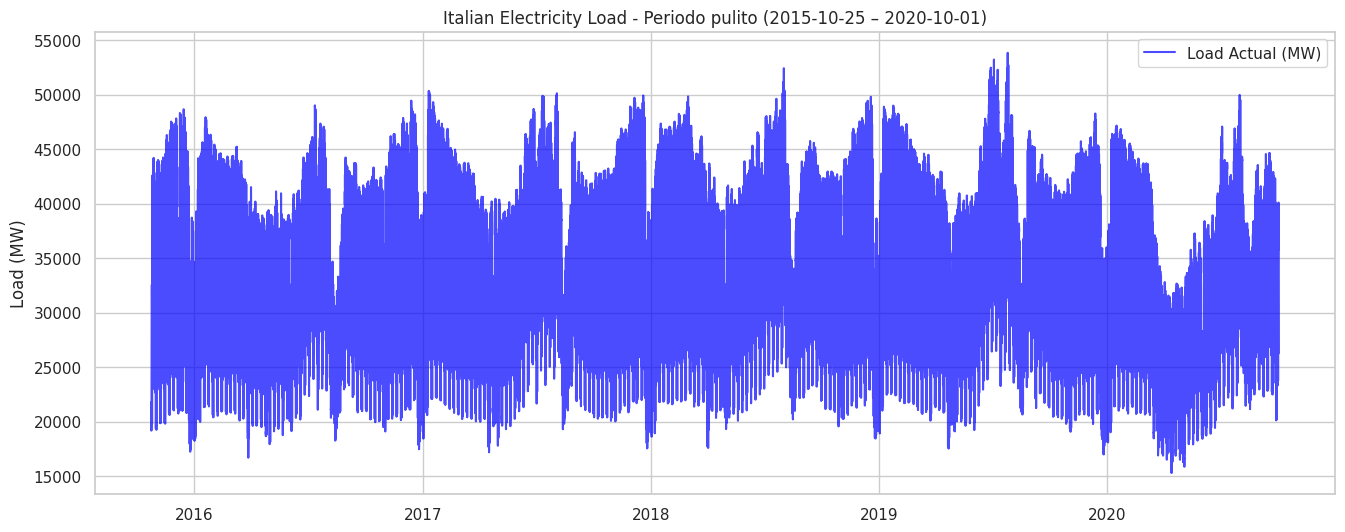

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style="whitegrid")

# Plot 1: Load full period (overview) – periodo pulito
plt.figure(figsize=(16, 6))
plt.plot(df_clean.index, df_clean['IT_load_actual_entsoe_transparency'], color='blue', alpha=0.7, label='Load Actual (MW)')
plt.title(f'Italian Electricity Load - Periodo pulito ({df_clean.index.min().date()} – {df_clean.index.max().date()})')
plt.ylabel('Load (MW)')
plt.grid(True)
plt.legend()
plt.show()

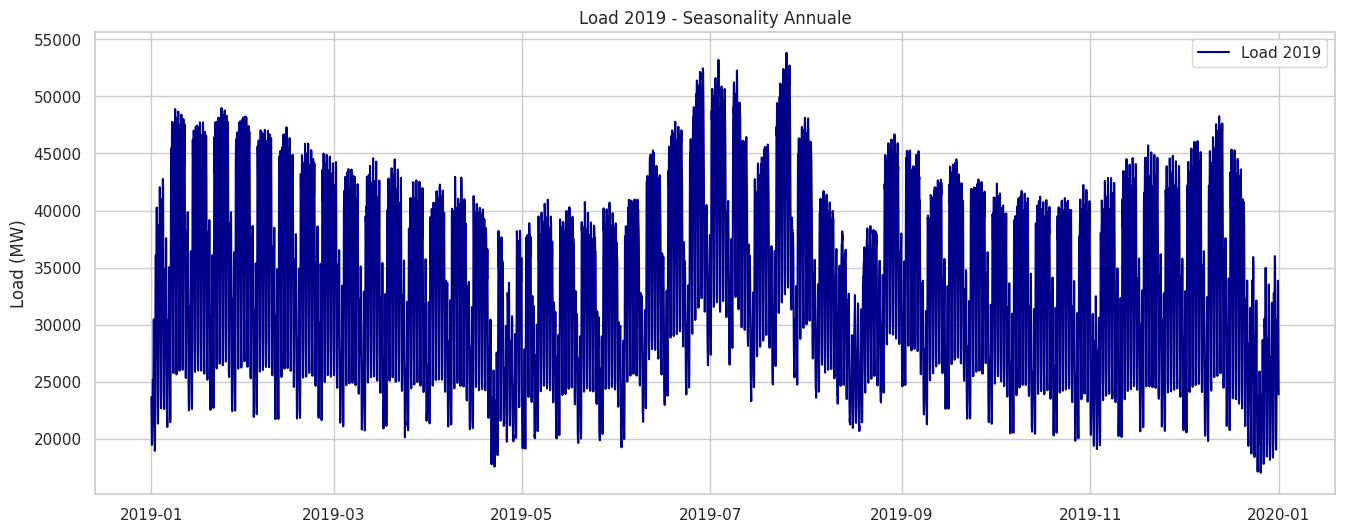

In [76]:
# Plot 2: Zoom su 1 anno recente (2019 se disponibile, altrimenti ultimo anno pieno)

rom_tz = 'Europe/Rome'
# Make start_2019 and end_2019 timezone-aware to match df_model.index
start_2019 = pd.to_datetime('2019-01-01 00:00:00').tz_localize(rom_tz)
end_2019   = pd.to_datetime('2019-12-31 23:00:00').tz_localize(rom_tz)

if start_2019 <= df_model.index.max() and end_2019 >= df_model.index.min():
    # 2019 è nel range → usalo
    df_year = df_model.loc[start_2019:end_2019].copy()
    year_label = 2019
else:
    # Calcola ultimo anno pieno disponibile
    max_date = df_model.index.max()
    last_full_year = max_date.year - 1  # anno precedente per sicurezza (evita anni parziali)

    # Make start_year and end_year timezone-aware
    start_year = pd.to_datetime(f"{last_full_year}-01-01 00:00:00").tz_localize(rom_tz)
    end_year   = pd.to_datetime(f"{last_full_year}-12-31 23:00:00").tz_localize(rom_tz)

    df_year = df_model.loc[start_year:end_year].copy()
    year_label = last_full_year

# Se df_year vuoto per qualche motivo (raro), fallback a tutto il periodo
if df_year.empty:
    df_year = df_model.copy()
    year_label = f"intero periodo pulito ({df_model.index.min().year}-{df_model.index.max().year})"

# Plot
plt.figure(figsize=(16, 6))
plt.plot(df_year.index, df_year['IT_load_actual_entsoe_transparency'], color='darkblue', label=f'Load {year_label}')
plt.title(f'Load {year_label} - Seasonality Annuale')
plt.ylabel('Load (MW)')
plt.grid(True)
plt.legend()
plt.show()

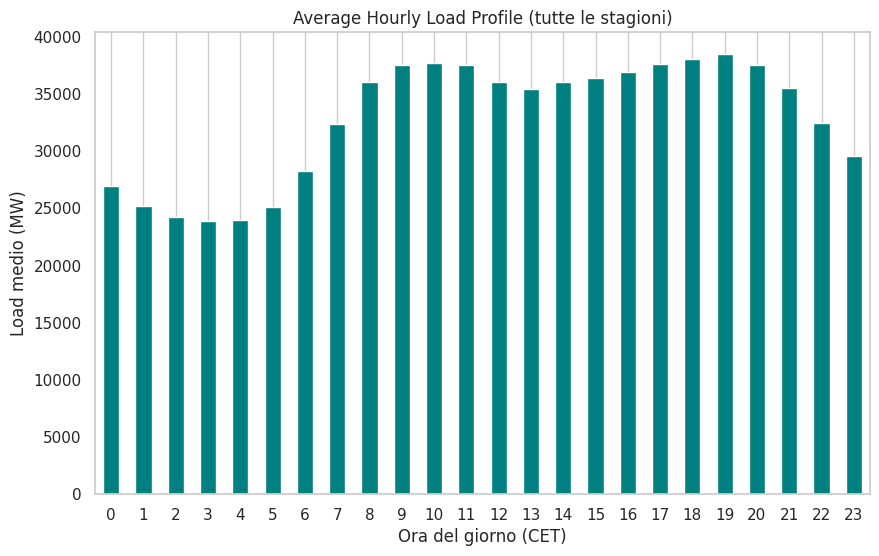

Picco medio orario più alto: 38461.791458679974 MW alle ore 19
Minimo medio notturno: 23864.557404326122 MW alle ore 3


In [77]:
# Plot 3: Average Hourly Load Profile (media per ora del giorno)

# Aggiungi colonna 'hour' se non c'è già
if 'hour' not in df_model.columns:
    df_model['hour'] = df_model.index.hour

# Media per ora
hourly_avg = df_model.groupby('hour')['IT_load_actual_entsoe_transparency'].mean()

plt.figure(figsize=(10, 6))
hourly_avg.plot(kind='bar', color='teal')
plt.title('Average Hourly Load Profile (tutte le stagioni)')
plt.xlabel('Ora del giorno (CET)')
plt.ylabel('Load medio (MW)')
plt.grid(axis='y')
plt.xticks(range(0, 24), range(0, 24), rotation=0)
plt.show()

# Insight rapido da notare qui sotto
print("Picco medio orario più alto:", hourly_avg.max(), "MW alle ore", hourly_avg.idxmax())
print("Minimo medio notturno:", hourly_avg.min(), "MW alle ore", hourly_avg.idxmin())



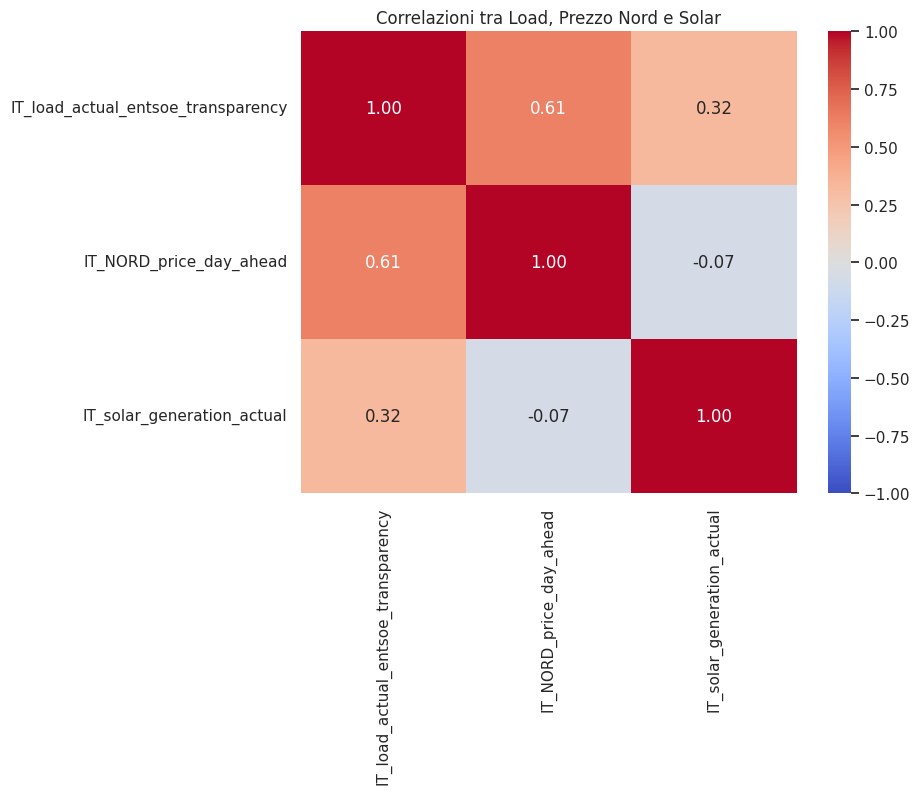

Correlazione Load vs Prezzo Nord: 0.612
Correlazione Load vs Solar: 0.321


In [78]:
# Correlation matrix (focus sulle feature rimaste)

corr_cols = ['IT_load_actual_entsoe_transparency',
             'IT_NORD_price_day_ahead',
             'IT_solar_generation_actual']

corr = df_model[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlazioni tra Load, Prezzo Nord e Solar')
plt.show()

print("Correlazione Load vs Prezzo Nord:", corr.iloc[0,1].round(3))
print("Correlazione Load vs Solar:", corr.iloc[0,2].round(3))


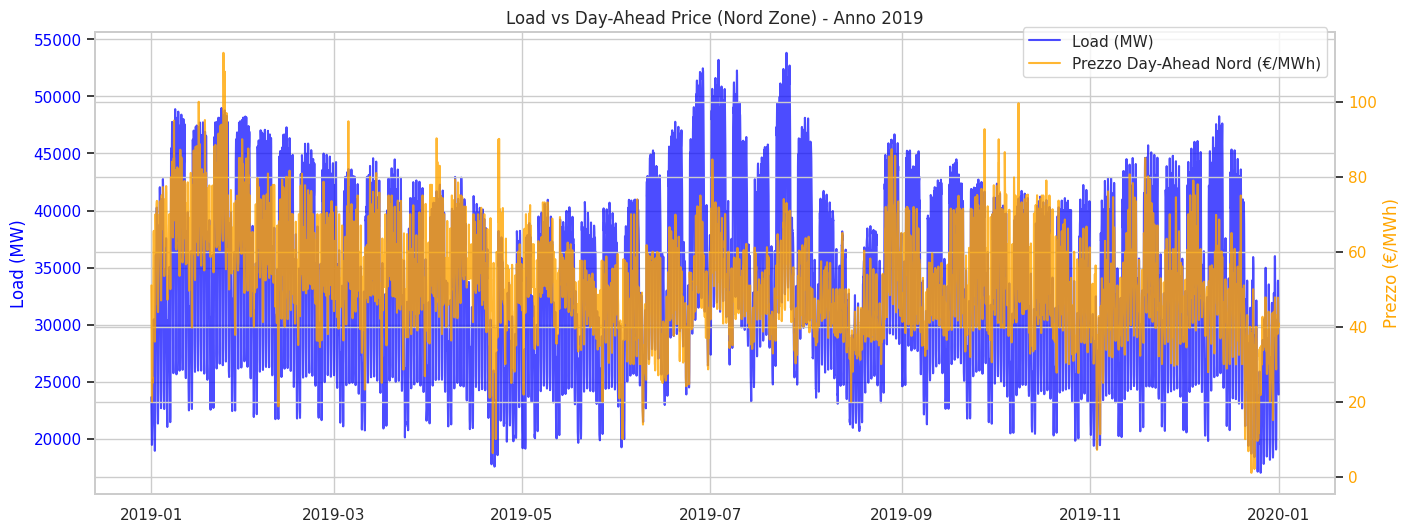

In [80]:
# Dual axis: Load vs Prezzo Nord (zoom su 1-2 anni per leggibilità)

# Zoom su ultimo anno disponibile per non sovraccaricare il plot
max_date = df_model.index.max()
rom_tz = 'Europe/Rome'
# Localize start_zoom and end_zoom to 'Europe/Rome' timezone
start_zoom = pd.to_datetime(f"{max_date.year - 1}-01-01").tz_localize(rom_tz)
end_zoom   = pd.to_datetime(f"{max_date.year - 1}-12-31 23:00:00").tz_localize(rom_tz)

df_zoom = df_model.loc[start_zoom:end_zoom]

fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.plot(df_zoom.index, df_zoom['IT_load_actual_entsoe_transparency'], color='blue', label='Load (MW)', alpha=0.7)
ax1.set_ylabel('Load (MW)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df_zoom.index, df_zoom['IT_NORD_price_day_ahead'], color='orange', label='Prezzo Day-Ahead Nord (€/MWh)', alpha=0.8)
ax2.set_ylabel('Prezzo (€/MWh)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title(f'Load vs Day-Ahead Price (Nord Zone) - Anno {df_zoom.index.year[0]}')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.grid(True)
plt.show()

In [84]:
# Outliers detection (su load)

z_scores = stats.zscore(df_model['IT_load_actual_entsoe_transparency'])
outliers = df_model[abs(z_scores) > 4]

print(f"Outliers rilevati (|z| > 4): {len(outliers)} righe")
if not outliers.empty:
    print("Prime righe outlier:")
    print(outliers.head())
    print("\nDate outlier:", outliers.index[:5])
else:
    print("Nessun outlier estremo (>4 std dev) – load molto stabile")

Outliers rilevati (|z| > 4): 0 righe
Nessun outlier estremo (>4 std dev) – load molto stabile


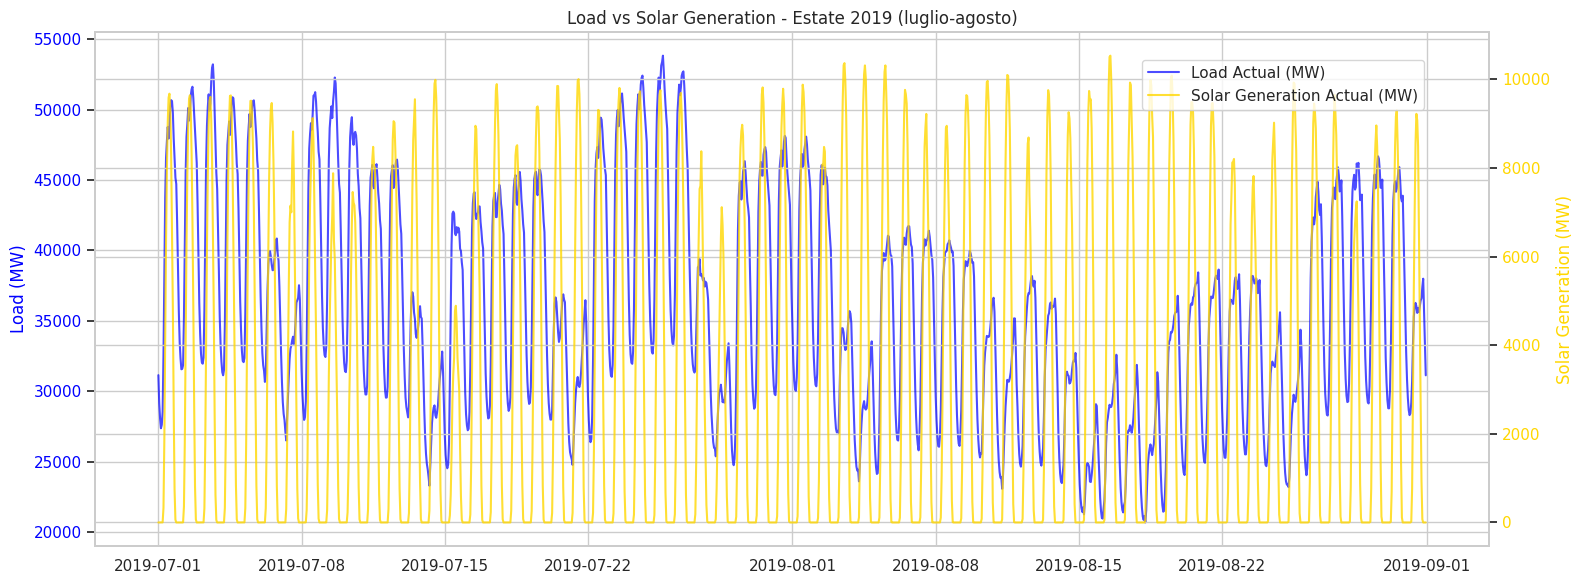

Correlazione Load vs Solar solo in estate: r = 0.429
Osservazione: se r diventa negativo o più basso, l'effetto riduzione net-load è visibile intraday/estivo.


In [86]:
# Plot extra: Zoom su un'estate (es. luglio-agosto 2019) – Load vs Solar generation
rom_tz = 'Europe/Rome'
# Localize start_summer and end_summer to 'Europe/Rome' timezone
start_summer = pd.to_datetime('2019-07-01 00:00:00').tz_localize(rom_tz)
end_summer   = pd.to_datetime('2019-08-31 23:00:00').tz_localize(rom_tz)

# Se l'anno non è disponibile, prendi l'estate più recente nel dataset
if start_summer > df_model.index.max():
    last_year = df_model.index.max().year
    start_summer = pd.to_datetime(f"{last_year}-07-01 00:00:00").tz_localize(rom_tz)
    end_summer   = pd.to_datetime(f"{last_year}-08-31 23:00:00").tz_localize(rom_tz)

df_summer = df_model.loc[start_summer:end_summer].copy()

fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.plot(df_summer.index, df_summer['IT_load_actual_entsoe_transparency'], color='blue', label='Load Actual (MW)', alpha=0.7)
ax1.set_ylabel('Load (MW)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df_summer.index, df_summer['IT_solar_generation_actual'], color='gold', label='Solar Generation Actual (MW)', alpha=0.8)
ax2.set_ylabel('Solar Generation (MW)', color='gold')
ax2.tick_params(axis='y', labelcolor='gold')

plt.title(f'Load vs Solar Generation - Estate {df_summer.index.year[0]} (luglio-agosto)')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.grid(True)
plt.tight_layout()
plt.show()

# Insight rapido
summer_corr = df_summer[['IT_load_actual_entsoe_transparency', 'IT_solar_generation_actual']].corr().iloc[0,1]
print(f"Correlazione Load vs Solar solo in estate: r = {summer_corr:.3f}")
print("Osservazione: se r diventa negativo o più basso, l'effetto riduzione net-load è visibile intraday/estivo.")


### 4. Feature Engineering


### 5. Baseline Model: Prophet


### 6. Advanced Model: LSTM


### 7. Model Evaluation & ROI Simulation


### 8. MLOps Tracking with MLflow


### 9. Deployment-ready Dashboard (Streamlit preview)


### 10. Next Steps & Production Path


### Appendix: Lessons Learned